In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


all_data = np.load("./all_data.npy", allow_pickle=True)

dates = all_data[:, 0]  # 日期
wind = all_data[:, 1]  # 万德全A
hs300 = all_data[:, 2]  # 沪深300
citic = all_data[:, 3:]  # 中信行情

print('数据开始时间',dates[0])
print('数据结束时间',dates[-1])
print('长度',len(dates))

# 2005-2021年数据 2005-2011年是样本内数据 12-21年是样本外数据

N_beta = 200
# idx 0-200 2008-2012; idx 500-700 2017-2021
idx_start = 0
idx_end = 700 

data = np.hstack((wind.reshape(-1,1)/100.0, citic/100.0))
data = data.astype(float)

# beta
beta_mat = np.zeros((data.shape[0] - N_beta, data.shape[1] - 1))
for i in range(beta_mat.shape[0]):
    # beta = np.array(np.cov(data[i:i+N_beta, :].T)[0,:])
    beta = np.diag(np.cov(data[i:i+N_beta, :].T))
    beta = beta[1:] / beta[0]
    beta_mat[i, :] = beta

# spearman
ret_mat = data[N_beta-1:, :]
spearman = []
for i in range(beta_mat.shape[0]):
    spearman.append(stats.spearmanr(ret_mat[i+1, 1:] / ret_mat[i, 1:] - 1, beta_mat[i, :])[0])

# 从 N_beta 开始可以购买
dates = dates[N_beta:]
hs300 = hs300[N_beta:]
wind = wind[N_beta:]

# 分样本内和样本外,start end 之间
dates = dates[idx_start:idx_end]
hs300 = hs300[idx_start:idx_end]
wind = wind[idx_start:idx_end]
spearman = spearman[idx_start:idx_end]

print('回测开始时间',dates[0])
print('回测结束时间',dates[-1])
print('长度',len(dates))

数据开始时间 2005-01-14 00:00:00
数据结束时间 2021-10-29 00:00:00
长度 856
回测开始时间 2008-01-25 00:00:00
回测结束时间 2021-09-17 00:00:00
长度 700


In [131]:
from utils import forward_chunduo as forward

In [133]:
cur_res = forward(wind, spearman, threshold=0.07)
print('最终金额', cur_res['money_finale'])
print('时间', dates[0], dates[-1])
print('回报率', cur_res['Rp'])
print('夏普比率', cur_res['sharp'])


最终金额 4800069.0
时间 2008-01-25 00:00:00 2021-09-17 00:00:00
回报率 0.12358764665185284
夏普比率 0.7237385467830693


In [ ]:
# 研报30
cur_res = forward(hs300, spearman, threshold=0.08)

plt.figure(figsize=(20,10))
plt.plot(dates, hs300, lw=4, label='hs300', c='gray', alpha=0.7)
for i in cur_res['record']:
    if i[3][0][-2:] == '做多':
        plt.plot(dates[i[1][1]], i[2][1], '.', markersize=15, c='red', alpha=0.5)  # 红点
    else:
        plt.plot(dates[i[1][1]], i[2][1], '.', markersize=15, c='green', alpha=0.5)  # 绿点
plt.legend(prop={'size': 20})
plt.savefig('./30_buytime_term2.jpg')

In [ ]:
# 研报31
save = []
for i in cur_res['record']:
    rate = i[2][1] / i[2][0] - 1
    date = dates[i[1][1]]
    save.append([date, rate])

import pandas as pd

# prepare for data
data_df = pd.DataFrame(save) 
# change the index and column name
data_df.columns = ['time','rate']
# create and writer pd.DataFrame to excel
writer = pd.ExcelWriter('31_chart_money_rate.xlsx')
data_df.to_excel(writer,'sheet',float_format='%.5f') # float_format 控制精度
writer.save()
writer.close()

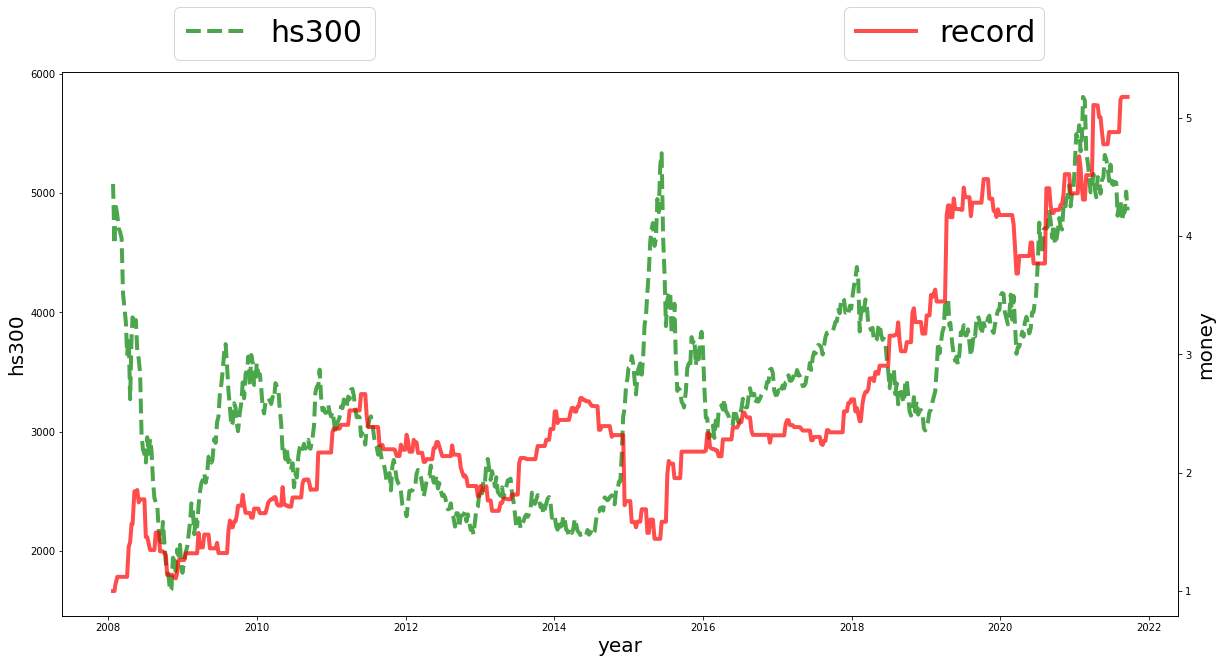

In [83]:
# 研报32
cur_res = forward(hs300, spearman, threshold=0.08)
record_money = np.array(cur_res['record_money']) / 1000000

fig = plt.figure(figsize=(20, 10))

ax1 = plt.axes()
ax1.plot(dates, hs300, '--', c='green', lw=4, label='hs300', alpha=0.7)
plt.legend(prop={'size': 30}, bbox_to_anchor=(0.1, 1.02, 0.18, 0.10), loc=0, ncol=2, mode="expand", borderaxespad=0.)

ax2 = ax1.twinx()
ax2.plot(dates, record_money, c='red', lw=4, label='record', alpha=0.7)
plt.legend(prop={'size': 30}, bbox_to_anchor=(0.7, 1.02, 0.18, 0.10), loc=0, ncol=2, mode="expand", borderaxespad=0.)

ax1.set_xlabel('year', {'size': 20})
ax1.set_ylabel('hs300', {'size': 20})
ax2.set_ylabel('money', {'size': 20})

plt.show()
# plt.savefig('./32_record.jpg')

In [ ]:
# 研报33 回撤
cur_res = forward(hs300, spearman, threshold=0.08)
record_money = np.array(cur_res['record_money']) / 1000000
backrate = [0]
pre_max = 0
for i in range(1, len(record_money)):
    if record_money[i] > record_money[i-1]:
        pre_max = record_money[i]
        backrate.append(0)
    else:
        backrate.append(record_money[i]/pre_max-1)

plt.figure(figsize=(20,10))
plt.plot(dates, backrate, lw=4, label='back rate', c='gray', alpha=0.8)
plt.legend(prop={'size': 20})
plt.savefig('./33_back_rate_term2.jpg')

In [121]:
# N_beta 与 threshold, 夏普比率

res = []
for shreshold in np.linspace(0.1, 0.3, 200):
    cur_res = forward(hs300, spearman, threshold=shreshold)
    res.append(cur_res['sharp'])

res_200 = res.copy()

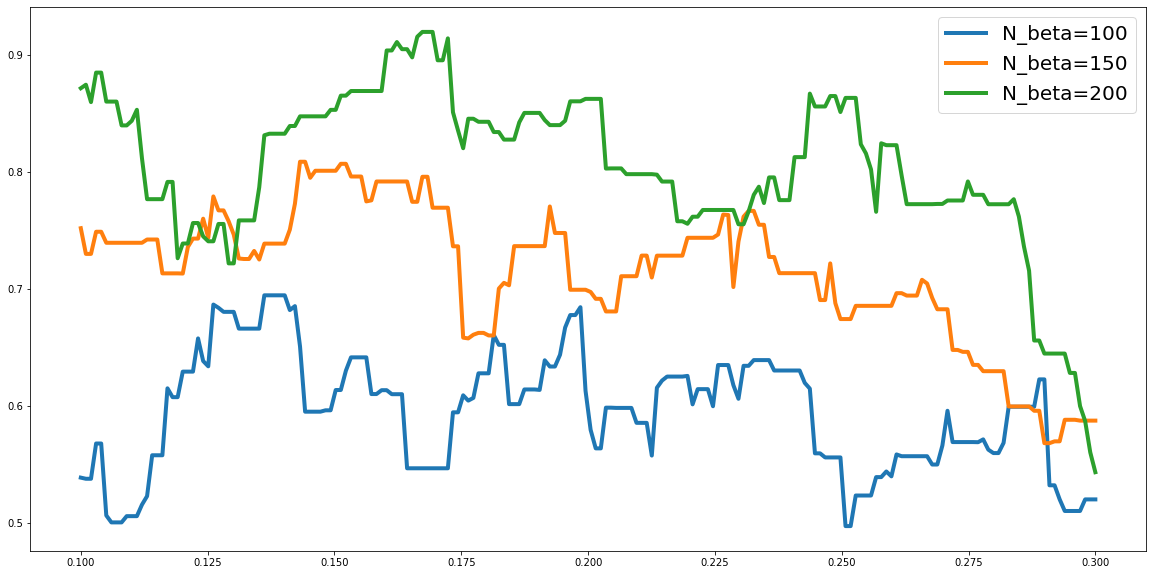

In [122]:
x = np.linspace(0.1, 0.3, 200)

plt.figure(figsize=(20,10))
plt.plot(x, res_100, lw=4, label='N_beta=100')
plt.plot(x, res_150, lw=4, label='N_beta=150')
plt.plot(x, res_200, lw=4, label='N_beta=200')
plt.legend(prop={'size': 20})
plt.savefig('./sharp.jpg')